# 0. Install and Import Dependencies

In [ ]:
!pip list

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
#Dataset analyse by ml
# The dataset consists of up to 1000 utterances of 500 different words, spoken by hundreds of different speakers.
# All videos are 29 frames (1.16 seconds) in length, and the word occurs in the middle of the video.
# The word duration is given in the metadata, from which can determine the start and end frames.
# Dataset Visualization link : https://www.robots.ox.ac.uk/~vgg/data/lip_reading/visualisation.htm

In [ ]:
# Type of Data
# Video Type MPG / MP4 format

#CATEGORY - The data is categorized into pre-training, training, validation, and test sets.
#Each covering different time frames and providing a robust foundation for the project

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [4]:
import gdown

In [ ]:
url = 'https://thor.robots.ox.ac.uk/~vgg/data/lip_reading/data1/lrw-v1-partaa'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [65]:
# Feature Engineering
# To Extract frame from a video and convert them into a grayscale images - Frame level Features
# Grayscale images have only one channel, compared to three channels (red, green, and blue) in RGB images
# Converting to grayscale can help the model focus on these important features without being influenced by
#variations in color, lighting conditions, or color-specific details.
# Noise reduction - Noise in color channels might be less informative.

import cv2
import os


def extract_frames(video_path, output_folder):
    # Open the video file
    capture = cv2.VideoCapture('.\\data\\s1\\bbal6n.mpg')

    # Check if the video opened successfully
    if not capture.isOpened():
        print("Error opening video file")
        return

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    frame_count = 0

    # Loop through the frames
    while True:
        ret, frame = capture.read()

        # Break the loop if we have reached the end of the video
        if not ret:
            break

        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Save the grayscale frame
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
        cv2.imwrite(frame_filename, gray_frame)

        frame_count += 1

    # Release the video capture object
    capture.release()

    print(f"{frame_count} frames extracted and saved to {output_folder}")


video_path = ".\\data\\s1\\bbal6n.mpg"
output_folder = ".\\data\\output\\folder"

extract_frames(video_path, output_folder)



75 frames extracted and saved to .\data\output\folder


In [ ]:
# Data Augmentation -Data augmentation is a common technique to enhance the variability
# of the training data and improve the generalization ability of the model



from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
from PIL import Image

def apply_data_augmentation(input_folder, output_folder, prefix, num_augmented_images_per_original=4):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create an ImageDataGenerator instance
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Loop through the images in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(input_folder, filename)

            # Load the image
            img = Image.open(image_path)
            img_array = plt.imread(image_path)  # for displaying

            # Reshape the image to (1, height, width, channels) for flow method
            img = img.resize((224, 224))  # Adjust the size as needed
            img_array = img_array.reshape((1,) + img_array.shape)

            # Generate augmented images
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_folder, save_prefix=prefix, save_format='png'):
                i += 1
                if i >= num_augmented_images_per_original:
                    break  # Break the loop after generating the desired number of augmented images

# Example
input_folder = ".\\data\\img"
output_folder = ".\\data\\imgoutput"
prefix = "augmented"

apply_data_augmentation(input_folder, output_folder, prefix)

#The above function will apply various augmentations to each original image and
#save the augmented images with the specified prefix in the output folder.


In [ ]:
## Introducing variations in lighting conditions and background can be done
#through a combination of image processing techniques.

import cv2
import numpy as np
import os
import random

def introduce_variations(image_path, output_folder, num_variations=4):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load the original image
    original_image = cv2.imread(image_path)

    # Define the range of brightness variations
    brightness_factor_range = (0.7, 1.3)

    for i in range(num_variations):
        # Randomly adjust brightness
        brightness_factor = random.uniform(*brightness_factor_range)
        brightened_image = cv2.convertScaleAbs(original_image, alpha=brightness_factor, beta=0)

        # Generate a random background color with the same size as the brightened image
        background_color = np.random.randint(0, 256, size=brightened_image.shape, dtype=np.uint8)
        background_color_image = np.ones_like(brightened_image) * background_color

        # Combine the brightened image with the random background
        varied_image = cv2.addWeighted(brightened_image, 0.5, background_color_image, 0.5, 0)

        # Save the varied image
        output_path = os.path.join(output_folder, f"varied_image_{i}.png")
        cv2.imwrite(output_path, varied_image)

# Example usage
image_path = ".\\data\\img\\frame_0002.png"
output_folder = ".\\data\\output\\folder"
num_variations = 4

introduce_variations(image_path, output_folder, num_variations)


#This code will create variations of the original image by adjusting brightness and adding a random background color.
#The varied images will be saved in the specified output folder.


In [ ]:
#extract audio spectrograms - To convert the audio track of a video into spectrograms
# uses - Speech Recognition, Deep learning models can be trained on the spectrogram representations of spoken
#words or phrases to recognize and transcribe spoken language.
# Audio Classification:You can use audio spectrograms to classify different types of sounds or events in audio data.
#For example, classifying musical genres, identifying specific environmental sounds, or detecting anomalies in audio
#streams.

!pip install librosa
!pip install numpy --user --verbose


import cv2
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt


def extract_audio_spectrograms(video_path, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return

    frame_rate = cap.get(cv2.CAP_PROP_FPS)

    # Get the audio track from the video
    audio_track, _ = librosa.load(video_path, sr=None, mono=True)

    # Calculate the duration of each frame
    frame_duration = 1.0 / frame_rate

    # Calculate the spectrogram for each frame
    for i in range(len(audio_track)):
        start_time = i * frame_duration
        end_time = (i + 1) * frame_duration

        # Extract the audio segment corresponding to the current frame
        audio_segment = audio_track[int(start_time * len(audio_track)):int(end_time * len(audio_track))]

        # Compute the spectrogram
        spectrogram = librosa.feature.melspectrogram(y=audio_segment, sr=frame_rate)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        # Plot and save the spectrogram
        plt.figure(figsize=(8, 6))
        librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', sr=frame_rate, cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Spectrogram - Frame {i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.tight_layout()

        # Save the spectrogram as an image
        output_path = os.path.join(output_folder, f"spectrogram_frame_{i}.png")
        plt.savefig(output_path)
        plt.close()

    # Release the video capture object
    cap.release()


video_path = ".\\data\\s1\\bbal6n.mpg"
output_folder = ".\\data\\spectograms_output"

extract_audio_spectrograms(video_path, output_folder)

#This code will extract audio spectrograms for each frame of the video and save them as individual
#PNG images in the specified output folder.




In [ ]:
#Feature scaling and normalization are essential preprocessing steps to ensure that features are on a similar scale,
#which can improve the convergence of the model during training.

from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming you have a feature matrix X (replace this with your actual feature matrix)
# Each row of X represents a sample, and each column represents a feature

# Generate a random example feature matrix
np.random.seed(42)
X = np.random.rand(100, 10)  # 100 samples with 10 features each

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data and transform the data
X_scaled = scaler.fit_transform(X)


# Print the mean and standard deviation of each feature after scaling
print("Mean of each feature after scaling:\n", X_scaled.mean(axis=0))
print("Standard deviation of each feature after scaling:\n", X_scaled.std(axis=0))

#This function assumes have a feature matrix X. The StandardScaler is used to scale each feature
#to have a mean of 0 and a standard deviation of 1. After fitting the scaler to the data using fit_transform,
#we can use the scaled features (X_scaled) for training the model.



In [5]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [8]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [10]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [13]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

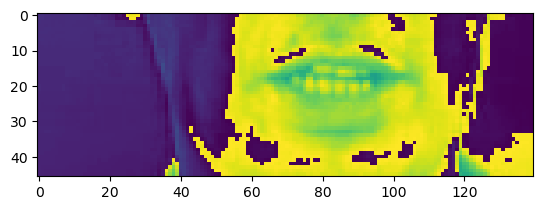

In [16]:
plt.imshow(frames[40])

In [17]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [19]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [20]:
from matplotlib import pyplot as plt

In [21]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(495)
test = data.skip(5)

In [22]:
len(test)

495

In [23]:
frames, alignments = data.as_numpy_iterator().next()

In [24]:
len(frames)

2

In [25]:
sample = data.as_numpy_iterator()

In [26]:
val = sample.next(); val[0]

array([[[[[ 1.2631532 ],
          [ 1.3815738 ],
          [ 1.1842061 ],
          ...,
          [ 0.3157883 ],
          [ 0.27631477],
          [ 0.27631477]],

         [[ 1.3421003 ],
          [ 1.4210473 ],
          [ 1.1842061 ],
          ...,
          [ 0.3157883 ],
          [ 0.27631477],
          [ 0.27631477]],

         [[ 1.2236797 ],
          [ 1.3421003 ],
          [ 1.0657855 ],
          ...,
          [ 0.3157883 ],
          [ 0.27631477],
          [ 0.27631477]],

         ...,

         [[ 1.1052591 ],
          [ 1.1052591 ],
          [ 1.1052591 ],
          ...,
          [ 0.03947354],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.1052591 ],
          [ 1.1052591 ],
          [ 1.0657855 ],
          ...,
          [ 0.03947354],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.1052591 ],
          [ 1.1052591 ],
          [ 1.0657855 ],
          ...,
          [ 0.03947354],
          [ 0.        ],
          

In [27]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.065752029418945]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

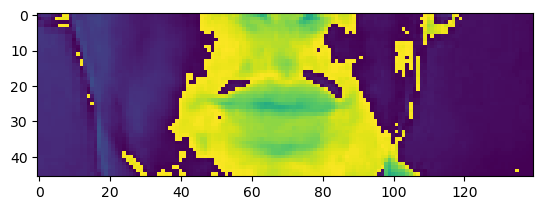

In [28]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [29]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with u four now'>

# 3. Design the Deep Neural Network

In [30]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [31]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [32]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                activation='relu',
                input_shape=(28,28,1))) #First Convolutional layer with input shape
model.add(Conv2D(64, (3,3), activation='relu')) #Second Convolutional layer
model.add(MaxPooling2D(pool_size=(2,2))) #MaxPooling layer
model.add(Flatten()) #Flatten layer for converting CNN codes to Dense layer input
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax')) #Activation layer with softmax

#Model Architecture Visualization
from IPython.display import SVG
from keras.utils.vis_ut import model_to_dot

%matplotlib inline
SCG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

#Setting up the model
#Define optimizer for training
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# Compiling sequential model with optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [34]:
5*17*75

6375

In [35]:
yhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [36]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'yyyggggggggggggggggggggggggggggggggggggggggggggggggggggqqqqqqgggggggggpppp!'>

In [37]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'yyyggggggggggggggggggggggggggggggggggggggggggggggggggggqqqqqqgggggggggpppp!'>

In [38]:
model.input_shape

(None, 75, 46, 140, 1)

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, Input, Reshape, Bidirectional, Attention
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (75, 46, 140, 1)

# CNN Model
def cnn_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    return model

# RNN Model
def rnn_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(None, 256)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dense(256, activation='relu'))
    return model

# Transformers Model
def transformers_model():
    inputs = Input(shape=input_shape[1:])
    x = Reshape((-1, input_shape[1]*input_shape[2]))(inputs)
    x = layers.MultiHeadAttention(num_heads=4, key_dim=256)(x, x)
    x = layers.GlobalAveragePooling1D()(x)
    x = Dense(256, activation='relu')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# LSTM Model
def lstm_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(None, 256)))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dense(256, activation='relu'))
    return model

# CNN + LSTM Model
# CNN + LSTM Model
def cnn_lstm_model():
    model = Sequential()
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu'), input_shape=(None, 46, 140, 1)))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dense(256, activation='relu'))
    return model

# Compile models
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss, metrics=['accuracy'])
    return model

# Instantiate models
cnn = compile_model(cnn_model())
rnn = compile_model(rnn_model())
transformers = compile_model(transformers_model())
lstm = compile_model(lstm_model())
cnn_lstm = compile_model(cnn_lstm_model())

# Display model summary
print("CNN Model:")
cnn.summary()

print("\nRNN Model:")
rnn.summary()

print("\nTransformers Model:")
transformers.summary()

print("\nLSTM Model:")
lstm.summary()

print("\nCNN + LSTM Model:")
cnn_lstm.summary()


CNN Model:
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 44, 138, 64)       640       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 22, 69, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 67, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 10, 33, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 31, 256)        295168    
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 4, 15,

# 4. Setup Training Options and Train

In [40]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [41]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [42]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [43]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [44]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [45]:
schedule_callback = LearningRateScheduler(scheduler)

In [46]:
example_callback = ProduceExample(test)

In [72]:
model.fit(train, validation_data=test, epochs=10, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [===================] - 2s 35us/steo - loss: 0.8283 - acc: 0.78896 - val_loss: 0.3996 - val acc: 0.8999
Epoch 2/10
48000/48000 [===================] - 2s 42us/steo - loss: 0.3700 - acc: 0.9017 - val_loss: 0.3092 - val acc: 0.9174
Epoch 3/10
48000/48000 [===================] - 2s 42us/steo - loss: 0.3087 - acc: 0.9148 - val_loss: 0.2740 - val acc: 0.9253
Epoch 4/10
48000/48000 [===================] - 2s 42us/steo - loss: 0.2770 - acc: 0.9230 - val_loss: 0.2531 - val acc: 0.9294
Epoch 5/10
48000/48000 [===================] - 2s 42us/steo - loss: 0.2537 - acc: 0.9291 - val_loss: 0.2348 - val acc: 0.9356
Epoch 6/10
48000/48000 [===================] - 2s 42us/steo - loss: 0.2349 - acc: 0.9337 - val_loss: 0.2198 - val acc: 0.9395
Epoch 7/10
48000/48000 [===================] - 3s 53us/steo - loss: 0.2194 - acc: 0.9382 - val_loss: 0.2009 - val acc: 0.9424
Epoch 8/10
48000/48000 [===================] - 3s 53us/steo - loss:

In [73]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
print('evaluation loss and acc')
print(loss_and_metrics)

10000/10000 [===================] - 0s 22us/step
evaluation loss and acc
0.180783282607794, 0.9471


# 5. Make a Prediction - Testing

In [ ]:
url = 'https://www.robots.ox.ac.uk/~vgg/data/lip_reading/visualisation.htm'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [52]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, MaxPool2D, Conv2D, Flatten
from tensorflow.keras.metrics import categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [53]:
model.load_weights('models/checkpoint')

In [54]:
test_data = test.as_numpy_iterator()

In [55]:
sample = test_data.next()

In [56]:
yhat = model.predict(sample[0])

1/1 [==============================] - 7s 7s/step


In [57]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f one soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by f five again'>]

In [58]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [59]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green in f one soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay white by five again'>]

# Test on a Video

In [60]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [61]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [62]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [63]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [64]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]